In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
c1 = 0.5 # now
c2 = 0.75 # in september
b = 1 # after september
h = 0.1

## Some preliminary study

In [3]:
def cost(y, A, B):
    return b * (A+B) / 2 + (c1-b) * y - (b+h) * (A-y)*(A-y) / (2*(A-B))

def solve_second_exact(A, B):
    kappa = (b - c1) / (b + h)
    y = A * (1-kappa) + B * kappa
    c = cost(y, A, B)
    return y, c

def solve_second_MC(A, B, K):
    scenarios = np.random.uniform(low=A, high=B, size=K)

    y = cp.Variable(1)
    t = cp.Variable(K)
    objective = cp.Minimize(cp.sum(t) / K)
    constraints = [y >= 0]

    for i, dk in enumerate(scenarios):
        constraints.append((c1-b) * y - t[i] <= -b * dk)
        constraints.append((c1+h) * y - t[i] <= h * dk)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    candidate = y.value[0]
    cost = prob.value
    return candidate, cost

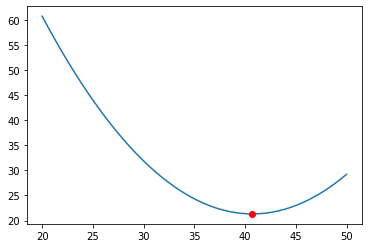

In [4]:
x = np.linspace(20, 50)
plt.plot(x, cost(x, 38, 44))
y, c = solve_second_exact(38, 44)
plt.plot(y, c, 'ro');

In [5]:
y1, cost1 = solve_second_MC(38, 44, 1000)
y2, cost2 = solve_second_exact(38, 44)
print(y1, cost1)
print(y2, cost2)

40.67415144530044 21.278250377452963
40.72727272727273 21.318181818181817


## Grid search (TODO)

In [47]:
def cost(y, A, B):
    if A == B:
        return max((c2 - b)*y + b*A, (c2+h)*y - h*A)
    return b * (A+B) / 2 + (c2-b) * y - (b+h) * (A-y)*(A-y) / (2*(A-B))

def solve_second_exact(A, B):
    kappa = (b - c2) / (b + h)
    y = A * (1-kappa) + B * kappa
    c = cost(y, A, B)
    return y, c

def Q(x, A, B):
    y, c = solve_second_exact(np.maximum(A - x, 0), np.maximum(B - x, 0))
    return c

N = 100

# samples ksi_i = (A_i, B_i) = (min(U_1, U_2), max(U_1, U_2)), where U_i ~ Uni[38, 44]
bounds = np.sort(np.random.uniform(low=38, high=44, size=(N,2)), axis=1)

def value(x):
    return np.sum(np.apply_along_axis(lambda bound: Q(x, bound[0], bound[1]), 1, bounds))

print(value(45))

0.0


## Complete linear program

In [4]:
N = 100
K = 50

# samples ksi_i = (A_i, B_i) = (min(U_1, U_2), max(U_1, U_2)), where U_i ~ Uni[38, 44]
bounds = np.sort(np.random.uniform(low=30, high=50, size=(N,2)), axis=1)

# samples d_{i,j} ~ Uni[A_i, B_i]
bounds_K = np.repeat(bounds, K, axis=0)
d = np.random.uniform(low=bounds_K[:,0], high=bounds_K[:,1])
d = d.reshape((N, K))

x = cp.Variable(1)
t = cp.Variable((N, K))
y = cp.Variable(N)

objective = cp.Minimize(c1 * x + cp.sum(t) / (N*K))

constraints = [x >= 0]

for i in range(N):
    constraints.append(y[i] >= 0)
    for j in range(K):
        constraints.append((c2-b) * y[i] - t[i,j] <= -b * (d[i,j] - x))
        constraints.append((c2+h) * y[i] - t[i,j] <= h * (d[i,j] - x))

prob = cp.Problem(objective, constraints)
prob.solve()

candidate = x.value
cost = prob.value

print(candidate, cost)
print(np.mean(y.value))

[38.22630701] 21.549790700476773
1.5798562290796208


## Monte Carlo for first stage only

optimal x: 39.36363636363636


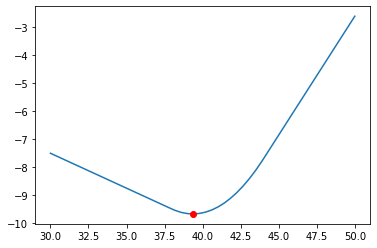

In [5]:
# for A <= x <= B
def d2(A, B):
    return (b+h) / (2*(B-A))
def d1(A, B):
    return (A/(A-B)) * (b+h) -c2 + c1
def d0(A, B):
    return ((b+h)*A*A) / (2 * (B-A))

# for x > B
Bd1 = b + h -c2 + c1
def Bd0(A, B):
    return (b+h) * ((B-A) / 2 - B)

# we define the cost function piecewise
def first(x, A, B):
    return d2(A, B) * x*x + d1(A, B) * x + d0(A, B)
def second(x, A, B):
    return Bd1 * x + Bd0(A, B)
def cost(x, A, B):
    if A <= x <= B:
        return first(x, A, B)
    elif x > B:
        return second(x, A, B)
    else:
        return (-c2 + c1) *x

def x_opt(d1, d2):
    return -d1/(2*d2) # extreme point of parabola
    
# solve an example for given A, B
A = 38
B = 44
xs = np.linspace(30, 50)
y = [cost(x, A, B) for x in xs]

plt.plot(xs, y)
s = x_opt(d1(A, B), d2(A, B))
plt.plot(s, cost(s, A, B), 'ro')
print(f'optimal x: {s}')

In [12]:
N = 10000000

# samples ksi_i = (A_i, B_i) = (min(U_1, U_2), max(U_1, U_2)), where U_i ~ Uni[38, 44]
bounds = np.sort(np.random.uniform(low=30, high=50, size=(N,2)), axis=1)

A, B = bounds[:,0], bounds[:,1]
D2 = np.mean(d2(A, B))
D1 = np.mean(d1(A, B))
# D0 = d0(A, B) # not necessary for solution

s = x_opt(D1, D2)
print(D1, D2)
print(s)

-71.92352248707292 0.901135660272006
39.907155857844394
